Investigation of LSTM networks ability to make multi step forecasts the logistic map

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt

from simulate_data import LogisticMapSimulator
from lstm_model import LSTM
from Prepare_data import DatasetLoader



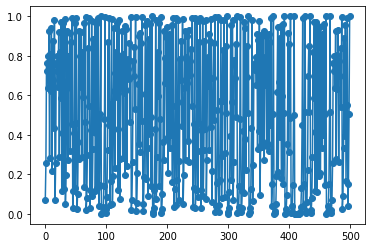

In [2]:
r_value = 4
obs_value = 0
burn = 100
num_timesteps = 600 #100 burn in + 500 observed points



logistic_simulator = LogisticMapSimulator(r_value, obs_value, num_timesteps)

values = logistic_simulator.simulate()


plt.plot(values, marker='o')
plt.show()


In [3]:
def train_model(model, loader, optimizer, loss_fn, X_train, y_train, X_test, y_test, n_epochs=500, validation_frequency=10):
    train_errors = []  
    test_errors = []   

    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            #print(y_pred.shape,y_batch.shape)
            loss = loss_fn(y_pred[:,:,-1].unsqueeze(2), y_batch)
            #loss = loss_fn(y_pred, y_batch)   
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % validation_frequency == 0:
            model.eval()
            with torch.no_grad():
                train_rmse = evaluate_model(model, X_train, y_train, loss_fn)  
                test_rmse = evaluate_model(model, X_test, y_test, loss_fn)  

            train_errors.append(train_rmse)
            test_errors.append(test_rmse)

            #print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

    # Plot the training and test errors
    plt.figure(figsize=(12, 6))
    plt.plot(range(0, n_epochs, validation_frequency), train_errors, label='Train RMSE')
    plt.plot(range(0, n_epochs, validation_frequency), test_errors, label='Test RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.title('Training and Test RMSE Over Epochs')
    plt.legend()
    plt.show()
    return train_errors, test_errors


def evaluate_model(model, X, y, loss_fn):
    model.eval()
    with torch.no_grad():
        y_pred = model(X)
        rmse = np.sqrt(loss_fn(y_pred[:,:,-1].unsqueeze(2), y))
        #rmse = np.sqrt(loss_fn(y_pred, y_batch))   
    return rmse.item()



In [4]:
forecast_steps = 3  # Adjust as needed
lag = 1 
batch_size = 50
train_split = 0.8

# Create an instance of the DatasetLoader
data_loader = DatasetLoader(dataset=values, lag=lag, forecast_steps=forecast_steps, batch_size=batch_size, train_split=train_split)


X_train, X_test, y_train, y_test = data_loader.X_train, data_loader.X_test, data_loader.y_train, data_loader.y_test


train_loader, test_loader = data_loader.get_data_loaders()



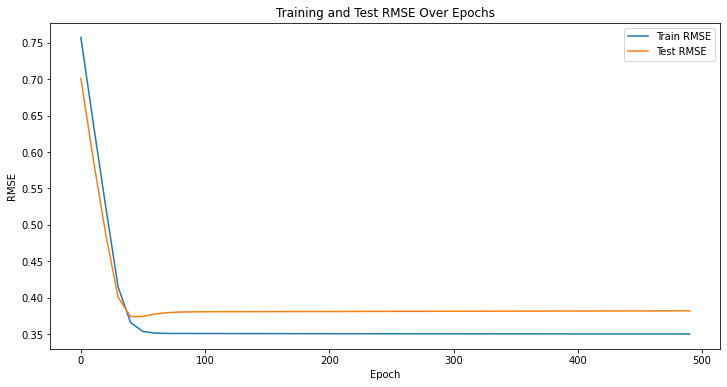

In [5]:
# Adjust the model instantiation
hidden_size = 10
num_layers = 2
model = LSTM(forecast_steps,hidden_size, num_layers)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
train_errors, test_errors = train_model(model, train_loader, optimizer, loss_fn, X_train, y_train, X_test, y_test)